In [26]:
import geopandas as gpd
import pandas as pd
import pickle
from zipfile import ZipFile
import tempfile
import numpy as np
from pathlib import Path
import os
from collections import defaultdict
pd.set_option('display.max_columns',None)

# requires local installation of ireiat package using 
from ireiat.util.cacheable import CACHE_PATH

### Purpose
Given the FAF5 regional association with counties and the county population, create an OD matrix (state_orig, county_orig, state_dest, county_dest)=tons

In [2]:
TARGET_FIELD = 'tons_2022'
TOLERANCE = 1e-6

In [3]:
county_pop_pdf = pd.read_csv(CACHE_PATH / 'data/raw/us_county_pop.csv',dtype={'STATE':str,'COUNTY':str})

In [4]:
with open(CACHE_PATH / 'data/transformed/faf_zone_id_to_state_county_id.pickle','rb') as fp:
    faf_id_to_county_id_map = pickle.load(fp)

In [5]:
actual_state_county_to_pop_map = dict()
for row in county_pop_pdf.loc[county_pop_pdf['COUNTY']!='000'].itertuples(): # ignore state totals
    actual_state_county_to_pop_map[(row.STATE,row.COUNTY)]=row.POPESTIMATE2022

In [6]:
faf_id_to_county_id_population_map = defaultdict(dict)

# look up the county population within each faf zone
for faf_id, vals in faf_id_to_county_id_map.items():
    for (state_id, county_id), pct_county_in_faf in vals.items():
        faf_id_to_county_id_population_map[faf_id][(state_id, county_id)] = actual_state_county_to_pop_map[(state_id, county_id)]*pct_county_in_faf

In [7]:
faf_total_population_map = dict()
for faf_id, vals_dict in faf_id_to_county_id_population_map.items():
    faf_total_population_map[faf_id] = sum(vals_dict.values())

# check that the totals are equal
assert sum(actual_state_county_to_pop_map.values()) == sum(faf_total_population_map.values())

In [8]:
# determine the percentage of the faf demand that should be allocated to the county based on the allocation metric of interest
faf_id_to_county_percent_map = defaultdict(dict)
for faf_id, vals in faf_id_to_county_id_population_map.items():
    for (state_id, county_id), population_portion in vals.items():
        faf_id_to_county_percent_map[faf_id][(state_id, county_id)]=population_portion/faf_total_population_map[faf_id]

# confirm that all the faf ids have a "total" allocation that sums to 1 (within some tolerance)
assert all([abs(sum(pop_map.values())-1)<TOLERANCE for pop_map in faf_id_to_county_percent_map.values()])

In [9]:
target_path = CACHE_PATH / 'data/raw/faf5_demand.zip'
zip = ZipFile(target_path)
with tempfile.TemporaryDirectory() as tmpdirname:
    zip.extractall(path=tmpdirname)
    target_csvs = [f for f in zip.namelist() if f.endswith('csv')]
    faf_pdf = pd.read_csv(zip.open(target_csvs[0]),dtype={'dms_orig':str, 'dms_dest':str})
    zip.close()

In [10]:
# faf_mode_map = {
#     1:  'Truck',
#     2:	'Rail',
#     3:	'Water',
#     4:	'Air (include truck-air)',
#     5:	'Multiple modes & mail',
#     6:	'Pipeline',
#     7:	'Other and unknown',
#     8:	'No domestic mode',
# }

In [11]:
is_by_truck = faf_pdf['dms_mode']==1 # by truck
faf_truck_pdf = faf_pdf.loc[is_by_truck]
total_road_tons_od_pdf = faf_truck_pdf.groupby(['dms_orig','dms_dest'],as_index=False)[[TARGET_FIELD]].sum()

In [12]:
faf_truck_pdf.sample(10)

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,tons_2017,tons_2018,tons_2019,tons_2020,tons_2021,tons_2022,tons_2023,tons_2025,tons_2030,tons_2035,tons_2040,tons_2045,tons_2050,value_2017,value_2018,value_2019,value_2020,value_2021,value_2022,value_2023,value_2025,value_2030,value_2035,value_2040,value_2045,value_2050,current_value_2018,current_value_2019,current_value_2020,current_value_2021,current_value_2022,tmiles_2017,tmiles_2018,tmiles_2019,tmiles_2020,tmiles_2021,tmiles_2022,tmiles_2023,tmiles_2025,tmiles_2030,tmiles_2035,tmiles_2040,tmiles_2045,tmiles_2050
762905,807.0,123,124,NaN,4.0,1,NaN,21,2,1,0.000000,0.000158,0.000966,0.006537,0.005450,0.005110,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007923,0.051507,0.369899,0.299615,0.281867,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008269,0.055543,0.406593,0.335664,0.323250,0.000000,0.000015,0.000092,0.000624,0.000520,0.000488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
390806,NaN,531,201,NaN,NaN,1,NaN,36,1,7,0.031295,0.032611,0.032034,0.028154,0.029575,0.031065,0.036854,0.042887,0.049288,0.056197,0.064014,0.072750,0.083582,0.168462,0.175544,0.172439,0.151552,0.159203,0.167225,0.198385,0.230860,0.265318,0.302512,0.344587,0.391616,0.449926,0.177476,0.175694,0.154526,0.168166,0.188755,0.058985,0.061465,0.060378,0.053065,0.055743,0.058552,0.069462,0.080833,0.092898,0.105920,0.120653,0.137119,0.157535
1631852,NaN,230,380,801.0,NaN,1,1.0,7,3,7,0.288661,1.029140,0.324395,0.430131,0.157629,0.263798,0.294943,0.302873,0.322786,0.346739,0.375555,0.410289,0.452243,0.415384,1.481487,0.466980,0.619190,0.226913,0.379748,0.424424,0.435835,0.464489,0.498958,0.540425,0.590407,0.650778,1.474300,0.479547,0.641897,0.245291,0.484294,0.532849,1.899725,0.598813,0.793993,0.290973,0.486954,0.544445,0.559084,0.595842,0.640057,0.693250,0.757367,0.834811
471407,NaN,223,411,NaN,NaN,1,NaN,40,1,8,0.052828,0.053108,0.052335,0.052504,0.052791,0.051044,0.054932,0.060442,0.072495,0.085975,0.099761,0.116385,0.131028,0.275542,0.277005,0.272970,0.273853,0.275348,0.266235,0.286515,0.315254,0.378120,0.448431,0.520334,0.607047,0.683421,0.282957,0.289511,0.288839,0.323727,0.349432,0.139869,0.140610,0.138564,0.139011,0.139771,0.135145,0.145440,0.160028,0.191940,0.227630,0.264130,0.308144,0.346914
1125676,807.0,399,219,NaN,3.0,1,NaN,33,2,3,0.000893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000669,0.000705,0.000780,0.000854,0.000933,0.001016,0.001105,0.021247,0.000000,0.000000,0.000000,0.000000,0.000000,0.015929,0.016775,0.018568,0.020308,0.022200,0.024185,0.026286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000239,0.000251,0.000278,0.000305,0.000333,0.000362,0.000394
472527,NaN,242,519,NaN,NaN,1,NaN,40,1,2,3.550142,3.568989,3.517003,3.528377,3.547649,3.430228,4.236623,5.824799,6.767723,7.604411,8.765937,10.075535,11.489908,42.466888,42.692337,42.070473,42.206540,42.437063,41.032480,50.678594,69.676387,80.955674,90.964157,104.858357,120.523801,137.442571,43.609727,44.619819,44.516276,49.893255,53.854948,0.617746,0.621025,0.611979,0.613959,0.617312,0.596880,0.737198,1.013550,1.177624,1.323213,1.525325,1.753203,1.999312
66768,NaN,511,121,NaN,NaN,1,NaN,13,1,4,21.488260,21.629771,21.256111,20.263429,21.180525,20.803614,17.393011,14.929175,14.178581,16.868799,16.758406,19.799158,21.185007,15.800449,15.904503,15.629748,14.899823,15.574170,15.297025,12.789188,10.977514,10.425598,12.403731,12.322558,14.558442,15.577465,16.074339,16.054520,15.387407,16.535096,17.620702,13.248033,13.335278,13.104907,12.492895,13.058307,12.825932,10.723213,9.204198,8.741439,10.400023,10.331963,12.206661,13.061070
1194785,808.0,251,500,NaN,3.0,1,NaN,34,2,2,0.000590,0.005121,0.038919,0.005519,0.035146,0.205136,0.000624,0.000684,0.000847,0.001038,0.001267,0.001538,0.001808,0.021014,0.030267,0.219801,0.029801,0.147890,0.860854,0.022208,0.024370,0.030156,0.036968,0.045112,0.

In [13]:
%%time
# create a (state_orig, county_orig, state_dest, county_dest) => tons map
county_od = defaultdict(float)
for row in total_road_tons_od_pdf.itertuples():
    constituent_orig_counties_map = faf_id_to_county_percent_map[row.dms_orig]
    constituent_dest_counties_map = faf_id_to_county_percent_map[row.dms_dest]
    for (state_orig, county_orig), pct_in_county_orig in constituent_orig_counties_map.items():
        for (state_dest, county_dest), pct_in_county_dest in constituent_dest_counties_map.items():
            county_od[(state_orig, county_orig, state_dest, county_dest)] += getattr(row,TARGET_FIELD)*pct_in_county_orig*pct_in_county_dest

assert abs(total_road_tons_od_pdf[TARGET_FIELD].sum()-sum(county_od.values()))<TOLERANCE

CPU times: total: 7.38 s
Wall time: 7.39 s


In [14]:
len(county_od)

9835245

In [15]:
county_od_tuples = [(*k, v) for k,v in county_od.items()]

In [16]:
county_od_pdf = pd.DataFrame(county_od_tuples,columns=['state_orig','county_orig','state_dest','county_dest','tons'])

In [17]:
county_od_pdf.describe()

,tons
count,9.835245e+06
mean,1.285232e+00
std,7.460633e+01
min,0.000000e+00
25%,1.938726e-03
50%,1.108630e-02
75%,6.775824e-02
max,8.467397e+04


In [18]:
county_od_pdf

,state_orig,county_orig,state_dest,county_dest,tons
0,01,009,01,009,63.080793
1,01,009,01,037,10.775631
2,01,009,01,121,85.543626
3,01,009,01,115,99.564878
4,01,009,01,043,96.101964
...,...,...,...,...,...
9835240,56,015,56,033,20.340211
9835241,56,015,56,027,1.508278
9835242,56,015,56,039,14.757680
9835243,56,015,56,035,5.553380


In [19]:
county_od_pdf['tons'].quantile(.98)

5.305011000119845

In [20]:
non_zero_county_od_pdf = county_od_pdf.loc[county_od_pdf['tons']>0].sort_values('tons')

In [21]:
non_zero_county_od_pdf['cum_tons'] = non_zero_county_od_pdf['tons'].cumsum()

<Axes: >

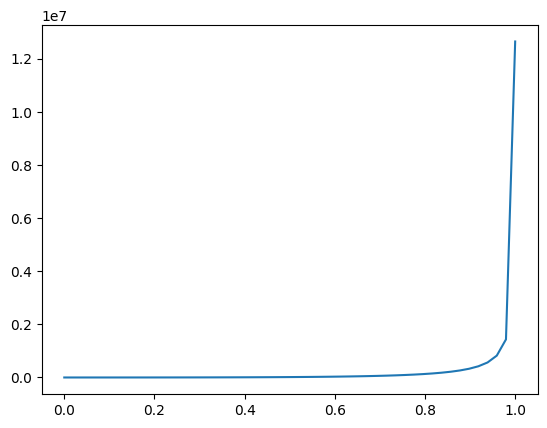

In [22]:
non_zero_county_od_pdf['cum_tons'].quantile(q=np.linspace(0,1,50)).plot()

In [27]:
# save as a parquet file to reduce file size
target_path = CACHE_PATH / 'data/transformed/county_od.parquet'
Path(os.path.dirname(target_path)).mkdir(parents=True,exist_ok=True)
county_od_pdf.to_parquet(target_path)